# Importing Libraries


In [46]:
# libraries
! pip install contractions
! pip install gensim
import contractions
import gensim
import os
import pandas as pd
import re
import nltk
import contractions
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from collections import Counter
from wordcloud import WordCloud

# Loading Data


In [47]:
# loading data
data_directory = '/content/Data 2014'

# Converting data into Dataframe
article_names = []
article_contents = []

# Looping through all files in the directory
for file in os.listdir(data_directory):
    if file.endswith('.txt'):  # Ensure it's a .txt file
        file_path = os.path.join(data_directory, file)

        # Read the content of the file
        with open(file_path, 'r', encoding='utf-8') as f:
            content = f.read()

        # Append file name and content to respective lists
        article_names.append(file)
        article_contents.append(content)


# Create a DataFrame
df = pd.DataFrame({
    'file_name': article_names,
    'content': article_contents})

# Exploratory Data Analysis (EDA)

In [48]:
# Basic overview of the dataset
print("df.info()")
df.info()
print("\ndf.head()\n")
print(df.head())

# Check for empty documents
df['content_length'] = df['content'].apply(lambda x: len(str(x)))
empty_docs = df[df['content_length'] == 0]
print(f"\nNumber of empty documents: {len(empty_docs)}")


df.info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 407 entries, 0 to 406
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  407 non-null    object
 1   content    407 non-null    object
dtypes: object(2)
memory usage: 6.5+ KB

df.head()

         file_name                                            content
0  Article 338.txt  AAP plagued by internal contradictions, lack o...
1  Article 102.txt  Vote on Account 2014: New government needs to ...
2   Article 37.txt  No power to Centre in communal violence bill: ...
3  Article 344.txt  Govt 'laid back' about appointing Navy Chief: ...
4  Article 191.txt  Sushilkumar Shinde threat to media reflects Co...

Number of empty documents: 0


count     407.000000
mean      359.882064
std       190.134321
min        83.000000
25%       251.000000
50%       317.000000
75%       408.500000
max      1700.000000
Name: doc_length, dtype: float64


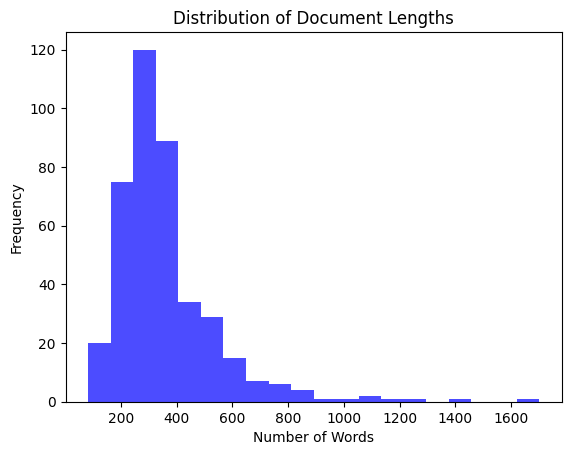

In [49]:
# Calculate document lengths in words
df['doc_length'] = df['content'].apply(lambda x: len(str(x).split()))

# Summary statistics
print(df['doc_length'].describe())

# Plot histogram of document lengths
plt.hist(df['doc_length'], bins=20, color='blue', alpha=0.7)
plt.title("Distribution of Document Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()


Most common raw words: [('the', 8272), ('to', 4059), ('of', 4026), ('and', 3118), ('in', 3031), ('a', 2539), ('is', 1922), ('for', 1551), ('that', 1541), ('on', 1278), ('he', 1079), ('said', 1041), ('has', 931), ('was', 861), ('not', 845), ('will', 839), ('be', 834), ('with', 831), ('it', 825), ('Congress', 789)]


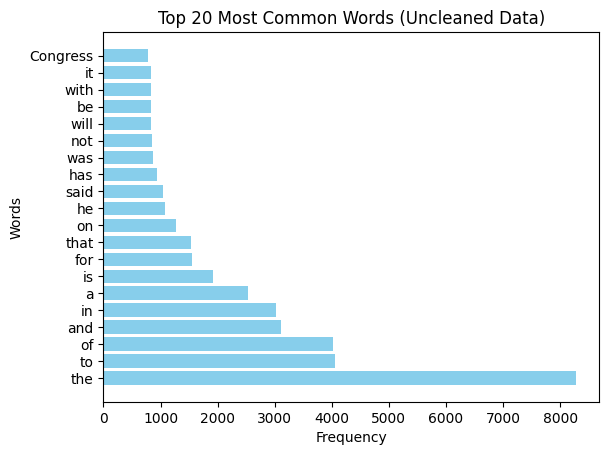

In [50]:
# Flatten all words in the corpus
all_words_raw = [word for doc in df['content'] for word in str(doc).split()]

# Count word frequencies
word_counts_raw = Counter(all_words_raw)
most_common_words_raw = word_counts_raw.most_common(20)
print("Most common raw words:", most_common_words_raw)

# Plot the most common words
words, counts = zip(*most_common_words_raw)
plt.barh(words, counts, color='skyblue')
plt.title("Top 20 Most Common Words (Uncleaned Data)")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()


count    407.000000
mean      58.108108
std       31.898440
min        9.000000
25%       38.000000
50%       51.000000
75%       69.000000
max      279.000000
Name: special_char_count, dtype: float64


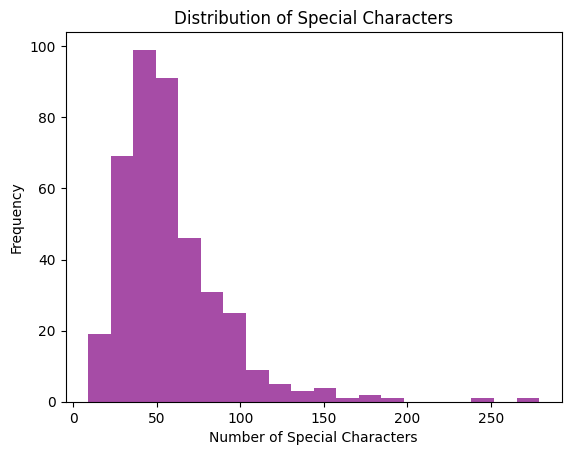

In [51]:
# Function to count special characters in a document
def count_special_chars(text):
    return len(re.findall(r'[^\w\s]', str(text)))

df['special_char_count'] = df['content'].apply(count_special_chars)

# Summary statistics
print(df['special_char_count'].describe())

# Plot distribution of special characters
plt.hist(df['special_char_count'], bins=20, color='purple', alpha=0.7)
plt.title("Distribution of Special Characters")
plt.xlabel("Number of Special Characters")
plt.ylabel("Frequency")
plt.show()


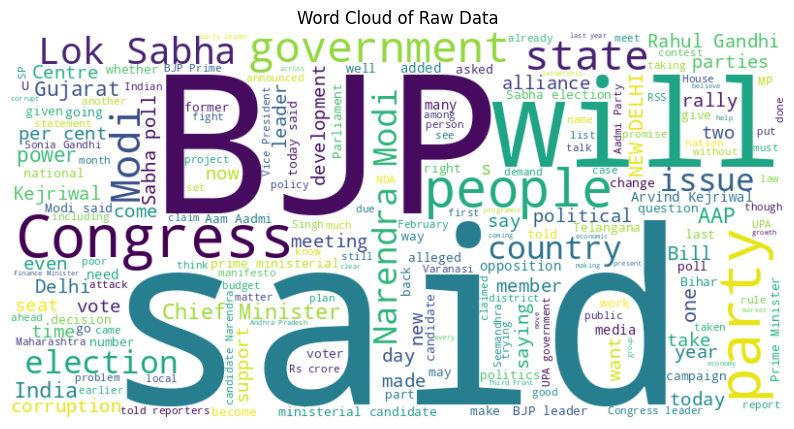

In [52]:
# Join all documents into one text
all_text_raw = ' '.join(str(doc) for doc in df['content'])

# Generate a word cloud
wordcloud_raw = WordCloud(width=800, height=400, background_color='white').generate(all_text_raw)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_raw, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Raw Data")
plt.show()

In [53]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Count stopwords in the raw corpus
stopword_counts_raw = sum(word.lower() in stop_words for word in all_words_raw)
print(f"\nNumber of stopwords in the dataset: {stopword_counts_raw}")



Number of stopwords in the dataset: 59603


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Cleaning Data


In [54]:
# cleaning data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

lemmatizer = WordNetLemmatizer()

special_words = ['modi','upa', 'kejriwal','kejriwals', 'party', 'gandhi', 'bjp', 'yadav', 'ghulam', 'azad' 'mulayam', 'singh', 'congress', 'aap', 'nitish', 'kumar', 'mamata', 'banerjee', 'narendra', 'rahul', 'said', 'shinde', 'anna', 'hazare', 'khurshid', 'trinamool', 'sonia', 'jdu', 'chidambaram', 'bsp', 'rjd', 'jaitley', 'arvind', 'dmk', 'aiadmk', 'dmdk', 'mayawati' ]

def expand_contractions(text):
    return contractions.fix(text)

def remove_single_characters(text):
    return re.sub(r'\b[a-zA-Z]\b', '', text)  # Removes isolated single letters

def preprocess_text(text):
    # Expand contractions
    text = expand_contractions(text)

    # Remove special characters, numbers, and extra spaces
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove single characters
    text = remove_single_characters(text)

    # Convert to lowercase
    text = text.lower()

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and word not in special_words]

    # Join tokens back into a string
    return ' '.join(tokens)

# Apply preprocessing to the content column
df['cleaned_content'] = df['content'].apply(preprocess_text)

print(df.head)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


<bound method NDFrame.head of            file_name                                            content  \
0    Article 338.txt  AAP plagued by internal contradictions, lack o...   
1    Article 102.txt  Vote on Account 2014: New government needs to ...   
2     Article 37.txt  No power to Centre in communal violence bill: ...   
3    Article 344.txt  Govt 'laid back' about appointing Navy Chief: ...   
4    Article 191.txt  Sushilkumar Shinde threat to media reflects Co...   
..               ...                                                ...   
402  Article 281.txt  Kejriwal has diverted from real issues: ATS ch...   
403  Article 100.txt  We do not accept that Telangana bill was intro...   
404  Article 140.txt  Seemandhra ministers discuss ways to safeguard...   
405   Article 70.txt  Kerala needs '3rd front' against Congress, CPI...   
406  Article 234.txt  Populism over fiscal austerity: Haryana govern...   

     content_length  doc_length  special_char_count  \
0             

Most common raw words: [('government', 658), ('minister', 637), ('leader', 561), ('people', 553), ('state', 545), ('also', 486), ('election', 482), ('delhi', 427), ('would', 417), ('sabha', 397), ('chief', 374), ('lok', 361), ('today', 356), ('party', 353), ('new', 339), ('candidate', 303), ('poll', 286), ('country', 284), ('gujarat', 273), ('issue', 269)]


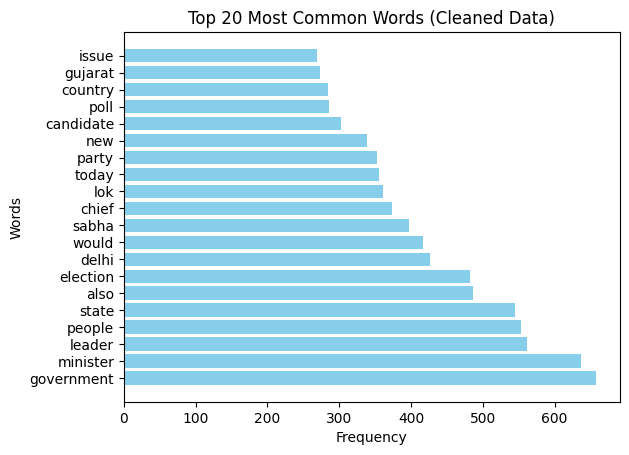

In [55]:
# Flatten all words in the corpus
all_words_raw = [word for doc in df['cleaned_content'] for word in str(doc).split()]

# Count word frequencies
word_counts_raw = Counter(all_words_raw)
most_common_words_raw = word_counts_raw.most_common(20)
print("Most common raw words:", most_common_words_raw)

# Plot the most common words
words, counts = zip(*most_common_words_raw)
plt.barh(words, counts, color='skyblue')
plt.title("Top 20 Most Common Words (Cleaned Data)")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()

count    407.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: special_char_count, dtype: float64


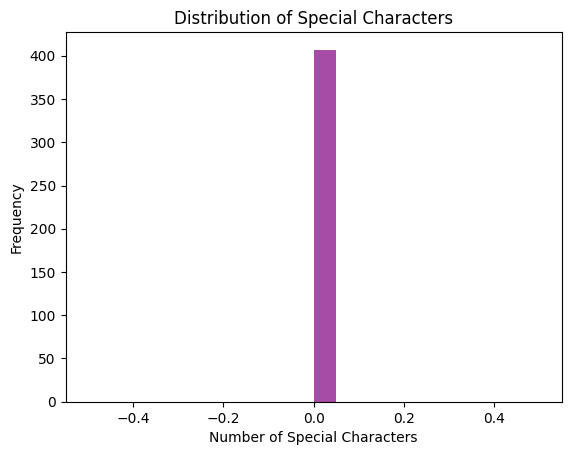

In [56]:
df['special_char_count'] = df['cleaned_content'].apply(count_special_chars)

# Summary statistics
print(df['special_char_count'].describe())

# Plot distribution of special characters
plt.hist(df['special_char_count'], bins=20, color='purple', alpha=0.7)
plt.title("Distribution of Special Characters")
plt.xlabel("Number of Special Characters")
plt.ylabel("Frequency")
plt.show()

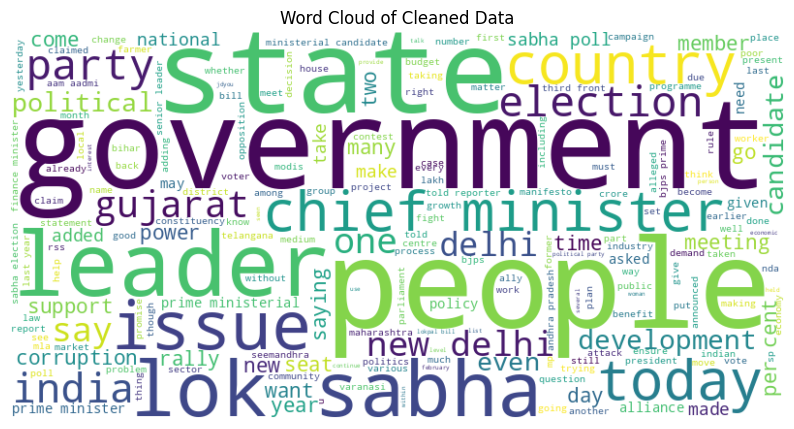

In [57]:
# Join all documents into one text
all_text_raw = ' '.join(str(doc) for doc in df['cleaned_content'])

# Generate a word cloud
wordcloud_raw = WordCloud(width=800, height=400, background_color='white').generate(all_text_raw)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_raw, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Cleaned Data")
plt.show()


# Prepairing Data


In [58]:
# Create a TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')  # Limit vocabulary to 5000 terms

# Fit and transform the cleaned content
dtm = vectorizer.fit_transform(df['cleaned_content'])

# Convert to a DataFrame (optional, for inspection)
dtm_df = pd.DataFrame(dtm.toarray(), columns=vectorizer.get_feature_names_out())

# Inspect the matrix
print(dtm_df.head())


     aadmi  aaj       aam      aaps   ab  abbas  abdul  abdullah  abdullahs  \
0  0.03253  0.0  0.062843  0.122668  0.0    0.0    0.0       0.0        0.0   
1  0.00000  0.0  0.000000  0.000000  0.0    0.0    0.0       0.0        0.0   
2  0.00000  0.0  0.000000  0.000000  0.0    0.0    0.0       0.0        0.0   
3  0.00000  0.0  0.000000  0.000000  0.0    0.0    0.0       0.0        0.0   
4  0.00000  0.0  0.000000  0.000000  0.0    0.0    0.0       0.0        0.0   

   abhi  ...  ysr  ysrcp  yusuf  yuva  zadafiya  zadaphia  zeher  zero  zonal  \
0   0.0  ...  0.0    0.0    0.0   0.0       0.0       0.0    0.0   0.0    0.0   
1   0.0  ...  0.0    0.0    0.0   0.0       0.0       0.0    0.0   0.0    0.0   
2   0.0  ...  0.0    0.0    0.0   0.0       0.0       0.0    0.0   0.0    0.0   
3   0.0  ...  0.0    0.0    0.0   0.0       0.0       0.0    0.0   0.0    0.0   
4   0.0  ...  0.0    0.0    0.0   0.0       0.0       0.0    0.0   0.0    0.0   

   zone  
0   0.0  
1   0.0  
2   0.0 

# Non-Negative Matrix Factorization

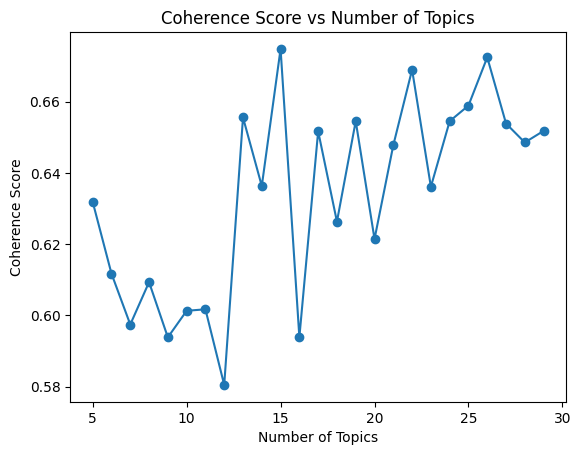

Number of Topics with highest coherence score: 15


In [59]:
def calculate_coherence_score(dtm, vectorizer, n_topics_range, texts):
    coherence_scores = []
    feature_names = vectorizer.get_feature_names_out()

    for n_topics in n_topics_range:
        # Fit NMF model
        nmf_model = NMF(n_components=n_topics, random_state=42, max_iter=1000)
        W = nmf_model.fit_transform(dtm)
        H = nmf_model.components_

        # Get the top words for each topic
        topics = []
        for topic_idx, topic in enumerate(H):
            top_words = [feature_names[i] for i in topic.argsort()[:-11:-1]]  # Top 10 words
            topics.append(top_words)

        # Create a gensim dictionary and corpus
        dictionary = Dictionary(texts)
        corpus = [dictionary.doc2bow(text) for text in texts]

        # Calculate coherence score
        coherence_model = CoherenceModel(
            topics=topics,
            texts=texts,
            dictionary=dictionary,
            coherence='c_v'
        )
        coherence_score = coherence_model.get_coherence()
        coherence_scores.append((n_topics, coherence_score))

    return coherence_scores


n_topics_range = range(5, 30)
texts = [doc.split() for doc in df['cleaned_content']]

# Calculate coherence scores
coherence_scores = calculate_coherence_score(dtm, vectorizer, n_topics_range, texts)

# Plot coherence scores
n_topics, scores = zip(*coherence_scores)
plt.plot(n_topics, scores, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Coherence Score vs Number of Topics')
plt.show()

# Print the optimal number of topics
optimal_n_topics = n_topics[scores.index(max(scores))]
print(f"Number of Topics with highest coherence score: {optimal_n_topics}")


Number of Topics: 5
Reconstruction Error: 19.31146887593381
Number of Topics: 6
Reconstruction Error: 19.225803504406294
Number of Topics: 7
Reconstruction Error: 19.140910523101834
Number of Topics: 8
Reconstruction Error: 19.064793924492434
Number of Topics: 9
Reconstruction Error: 18.998600201529268
Number of Topics: 10
Reconstruction Error: 18.924094095429528
Number of Topics: 11
Reconstruction Error: 18.859647647232364
Number of Topics: 12
Reconstruction Error: 18.79409512320347
Number of Topics: 13
Reconstruction Error: 18.741207014822344
Number of Topics: 14
Reconstruction Error: 18.678584627844785
Number of Topics: 15
Reconstruction Error: 18.626045480947194


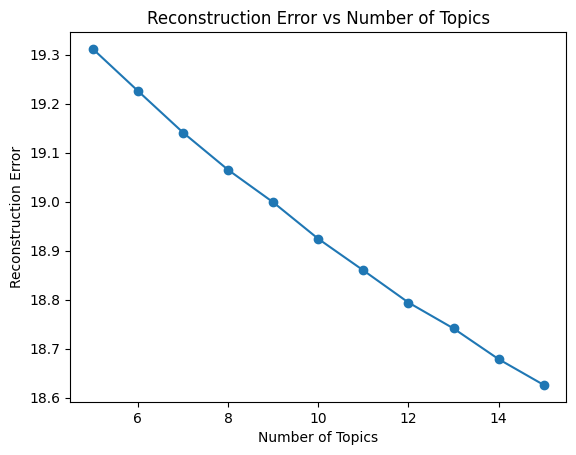

In [60]:
# Test NMF with different numbers of topics
errors = []
for n_topics in range(5, 16):
    nmf_model = NMF(n_components=n_topics, random_state=42, max_iter=1000)
    W = nmf_model.fit_transform(dtm)
    H = nmf_model.components_
    errors.append(nmf_model.reconstruction_err_)
    print(f"Number of Topics: {n_topics}")
    print(f"Reconstruction Error: {nmf_model.reconstruction_err_}")

# Plot the reconstruction errors
plt.plot(range(5, 16), errors, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error vs Number of Topics')
plt.show()


In [61]:
# Set number of topics
n_topics = 15

# Apply NMF
nmf_model = NMF(n_components=n_topics, random_state=42, max_iter=500)
W = nmf_model.fit_transform(dtm)  # Document-topic matrix
H = nmf_model.components_         # Topic-term matrix

# Get the top terms for each topic
feature_names = vectorizer.get_feature_names_out()
n_top_words = 10

for topic_idx, topic in enumerate(H):
    print(f"Topic #{topic_idx + 1}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))


Topic #1:
seat candidate sabha lok election poll varanasi leader campaign ticket
Topic #2:
budget interim government economy finance raja fiscal certain going election
Topic #3:
telangana seemandhra andhra region state tdp reddy pradesh mp jagan
Topic #4:
lokpal swaraj jurist panel rao appointment opposition selection sushma member
Topic #5:
gujarat state people development minister riot country rally chief prime
Topic #6:
manifesto growth cent sector india policy economic tax inflation job
Topic #7:
medium remark electronic jail leader social crush sold comment journalist
Topic #8:
alliance tamil nadu party ally seat poll chennai pmk touch
Topic #9:
bihar special status category bandh state betrayal jdyou seemandhra demand
Topic #10:
rss patel sardar mahatma assassination gandhi gandhiji secretary ec killed
Topic #11:
corrupt corruption list assam politics politician minister gogoi allegation chief
Topic #12:
hard money black fm working upas paralysis pension policy chidambarams
Topic